In [3]:
#Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import accuracy_score, classification_report
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

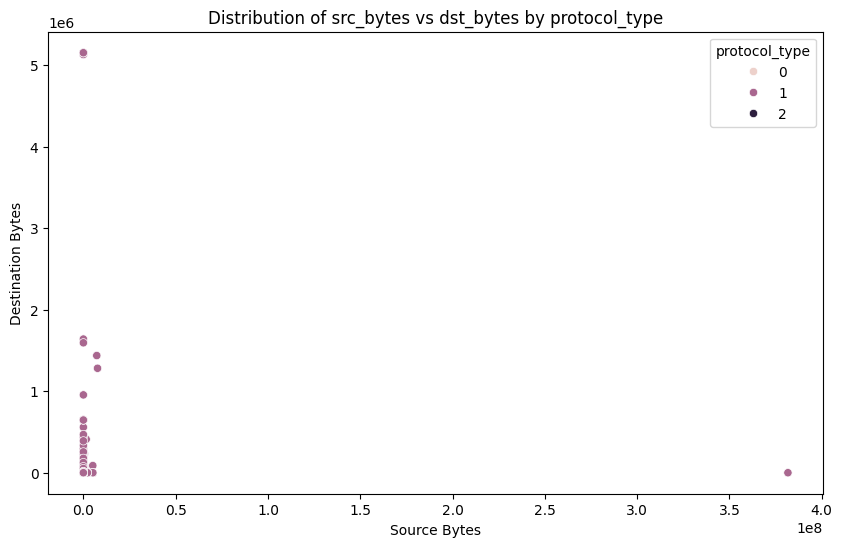

In [4]:
# Load the training data
train_df = pd.read_csv('Train_data.csv')
train_df.head()
print(train_df.info())

# Label Encoding for categorical columns
le_protocol = LabelEncoder()
train_df['protocol_type'] = le_protocol.fit_transform(train_df['protocol_type'])
joblib.dump(le_protocol, "le_protocol.pkl")

le_service = LabelEncoder()
train_df['service'] = le_service.fit_transform(train_df['service'])
joblib.dump(le_service, "le_service.pkl")

le_flag = LabelEncoder()
train_df['flag'] = le_flag.fit_transform(train_df['flag'])
joblib.dump(le_flag, "le_flag.pkl")

# Encode categorical features
label_encoders = {}
for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le
    joblib.dump(le, f"le_{col}.pkl")

# Create binary anomaly label
train_df["label"] = train_df["class"].apply(lambda x: 0 if x == "normal" else 1)

print("[INFO] Label encoding and binary conversion complete.")
train_df[['protocol_type', 'service', 'flag', 'class', 'label']].head()

# Extract features and labels
X = train_df.drop(columns=['class', 'label'])
y = train_df['label']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("[INFO] Features standardized.")

# Plot distribution of 'src_bytes' vs 'dst_bytes' for visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='src_bytes', y='dst_bytes', hue='protocol_type')
plt.title('Distribution of src_bytes vs dst_bytes by protocol_type')
plt.xlabel('Source Bytes')
plt.ylabel('Destination Bytes')
plt.show()


[INFO] BGMM trained.


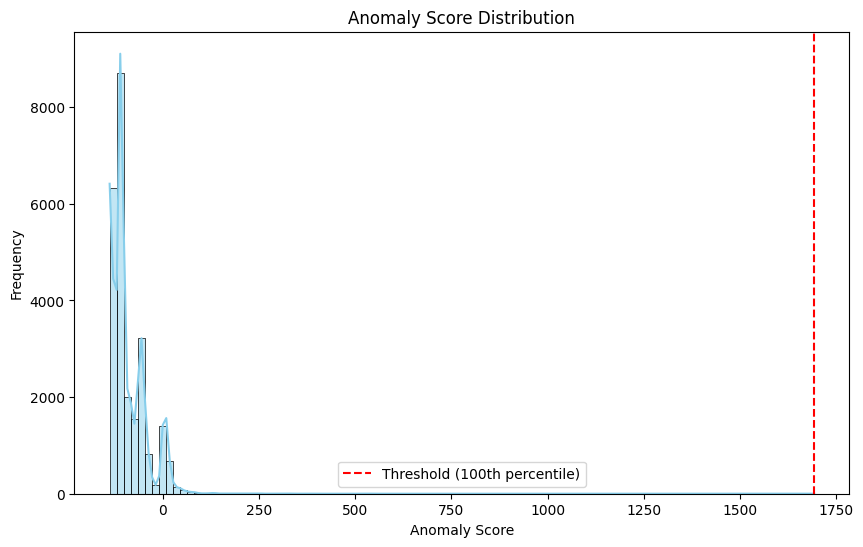

In [5]:
# Train the Bayesian_GMM model
bgmm = BayesianGaussianMixture(n_components=10, covariance_type='full', random_state=42)
bgmm.fit(X_scaled)

print("[INFO] BGMM trained.")

#Computing anomaly threshold using NORMAL data ,not attacked ones
scores = -bgmm.score_samples(X_scaled)

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=100, kde=True, color='skyblue')
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.axvline(np.percentile(scores, 100), color='red', linestyle='--', label='Threshold (100th percentile)')
plt.legend()
plt.show()


In [6]:
threshold = np.percentile(scores, 100)
y_pred = (scores > threshold).astype(int)

print(f"[INFO] Anomaly threshold set at 100th percentile: {threshold:.4f}")

[INFO] Anomaly threshold set at 100th percentile: 1692.5576


In [7]:
# Accuracy and report
acc = accuracy_score(y, y_pred)
print(f"[INFO] Accuracy: {acc * 100:.2f}%")
print(classification_report(y, y_pred, target_names=["Normal", "Anomaly"]))


[INFO] Accuracy: 53.39%
              precision    recall  f1-score   support

      Normal       0.53      1.00      0.70     13449
     Anomaly       0.00      0.00      0.00     11743

    accuracy                           0.53     25192
   macro avg       0.27      0.50      0.35     25192
weighted avg       0.29      0.53      0.37     25192



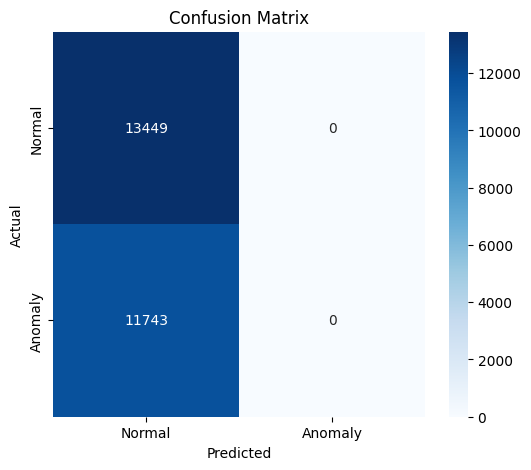

In [8]:
# Confusion matrix plot
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
